In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
# Set plot style
sns.set_theme(style="whitegrid")

# Tree Species

## Exploratory Data Analysis

In [3]:
# Load tree species dataset
tree_df = pd.read_excel("../../data/species.xlsx")

In [4]:
# Display the first few rows
print("First 5 rows:")
print(tree_df.head())

First 5 rows:
   species_id             species_name species_common_name  rainfall_mm_min  \
0           1  Casuarina equisetifolia            Ai-kakeu              200   
1           2          Tectona grandis             Ai-teka             1500   
2           3      Pterocarpus indicus               Ai-na              900   
3           4           Santalum album          Ai-kamelli              625   
4           5        Sterculia foetida            Ai-nitas             1100   

   rainfall_mm_max  temperature_celsius_min  temperature_celsius_max  \
0             3500                       10                       35   
1             2000                       16                       40   
2             2200                       22                       32   
3             1625                       10                       35   
4             1800                       18                       32   

   elevation_m_min  elevation_m_max  ph_min  ph_max  \
0                0     

In [5]:
# Display basic information about the dataset
print("\nDataset Info:")
print(tree_df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   species_id               20 non-null     int64  
 1   species_name             20 non-null     object 
 2   species_common_name      20 non-null     object 
 3   rainfall_mm_min          20 non-null     int64  
 4   rainfall_mm_max          20 non-null     int64  
 5   temperature_celsius_min  20 non-null     int64  
 6   temperature_celsius_max  20 non-null     int64  
 7   elevation_m_min          20 non-null     int64  
 8   elevation_m_max          20 non-null     int64  
 9   ph_min                   20 non-null     float64
 10  ph_max                   20 non-null     float64
 11  preferred_soil_texture   20 non-null     object 
 12  costal                   20 non-null     bool   
 13  riparian                 20 non-null     bool   
 14  nitrogen_fixi

In [6]:
# Select all numeric types (floats and integers)
tree_numerical_cols = tree_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove the id column
tree_numerical_cols.remove("species_id")

In [7]:
# Select object (string) types
tree_categorical_cols = tree_df.select_dtypes(include=["object"]).columns.tolist()

# Select boolean types
tree_boolean_cols = tree_df.select_dtypes(include=["bool"]).columns.tolist()

# Filter for columns with low cardinality (few unique values)
# This prevents plotting unique identifiers like 'species_name'
tree_categorical_cols = [
    col for col in tree_categorical_cols if tree_df[col].nunique() < 15
]

In [8]:
# Display descriptive statistics
print("\nDescriptive Statistics:")
print(tree_df.describe())


Descriptive Statistics:
       species_id  rainfall_mm_min  rainfall_mm_max  temperature_celsius_min  \
count    20.00000        20.000000        20.000000                20.000000   
mean     10.50000      1075.750000      2906.250000                19.200000   
std       5.91608       563.025836      1092.675224                 4.926833   
min       1.00000       200.000000      1200.000000                10.000000   
25%       5.75000       722.500000      2000.000000                16.750000   
50%      10.50000      1000.000000      2750.000000                20.000000   
75%      15.25000      1500.000000      4000.000000                22.000000   
max      20.00000      2500.000000      5000.000000                28.000000   

       temperature_celsius_max  elevation_m_min  elevation_m_max     ph_min  \
count                20.000000         20.00000        20.000000  20.000000   
mean                 32.500000         72.50000      1247.500000   5.395000   
std              

In [9]:
# Check for missing values
print("\nMissing Values:")
print(tree_df.isnull().sum())


Missing Values:
species_id                 0
species_name               0
species_common_name        0
rainfall_mm_min            0
rainfall_mm_max            0
temperature_celsius_min    0
temperature_celsius_max    0
elevation_m_min            0
elevation_m_max            0
ph_min                     0
ph_max                     0
preferred_soil_texture     0
costal                     0
riparian                   0
nitrogen_fixing            0
shade_tolerant             0
bank_stabilising           0
agroforestry_types         0
dtype: int64


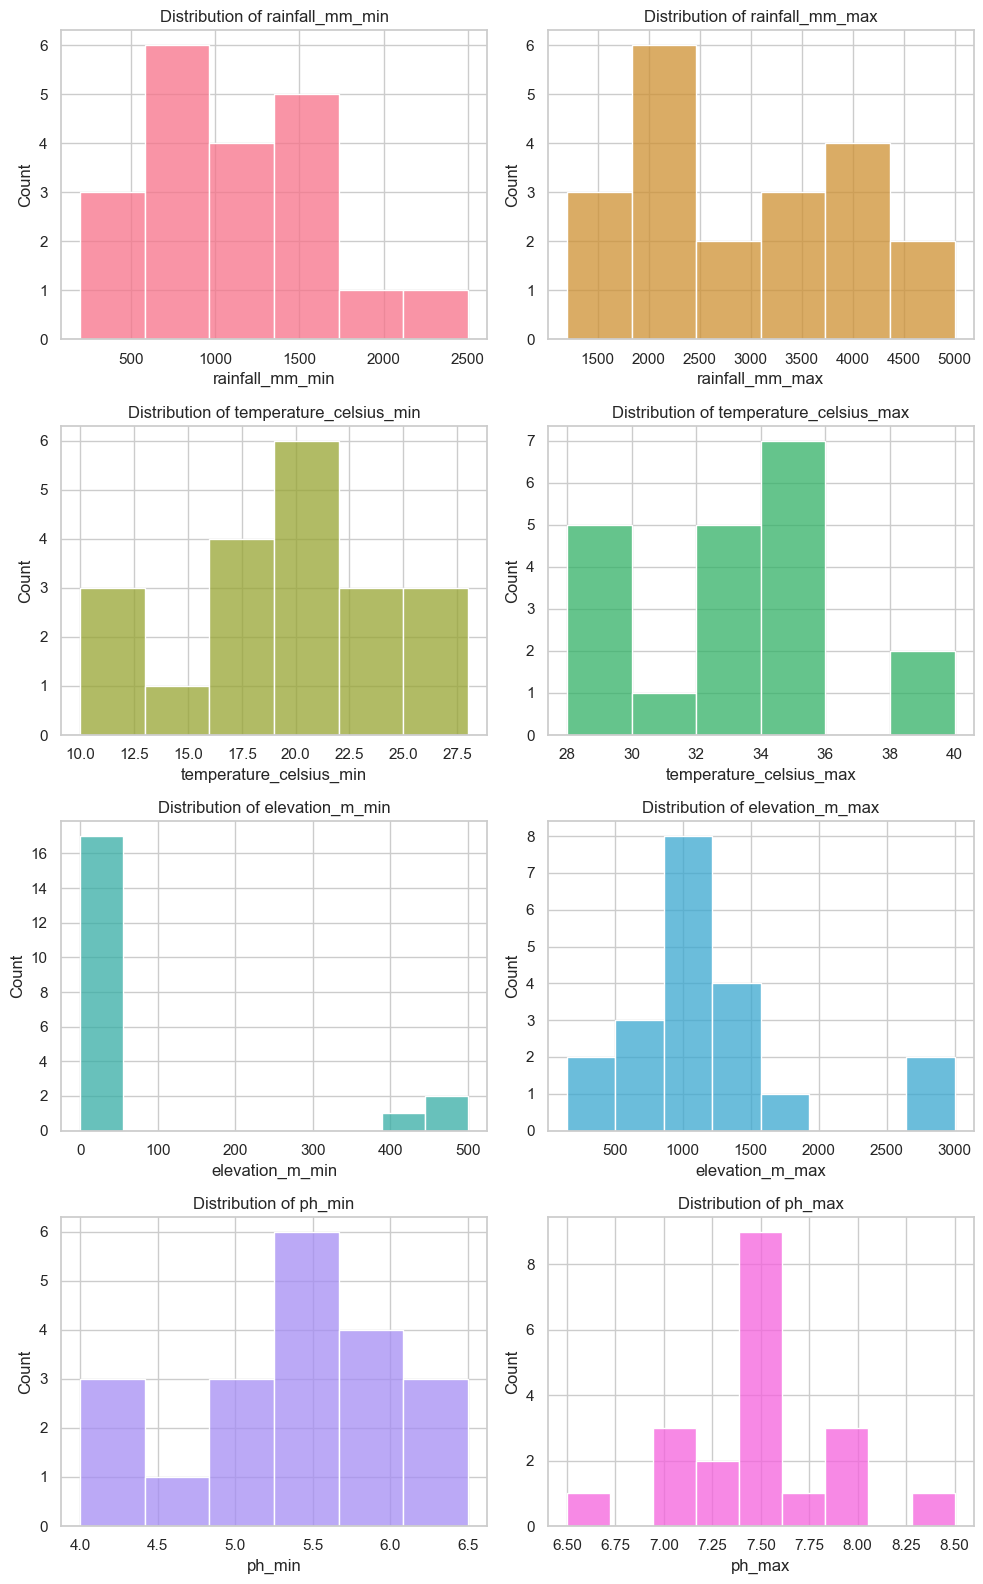

In [10]:
# Create histograms for numerical columns

# Generate a palette with enough unique colours
tree_colours = sns.color_palette("husl", len(tree_numerical_cols))

plt.figure(figsize=(10, 16))
for i, col in enumerate(tree_numerical_cols):
    plt.subplot(4, 2, i + 1)
    sns.histplot(tree_df[col], kde=False, color=tree_colours[i])
    plt.title(f"Distribution of {col}")
    plt.tight_layout()

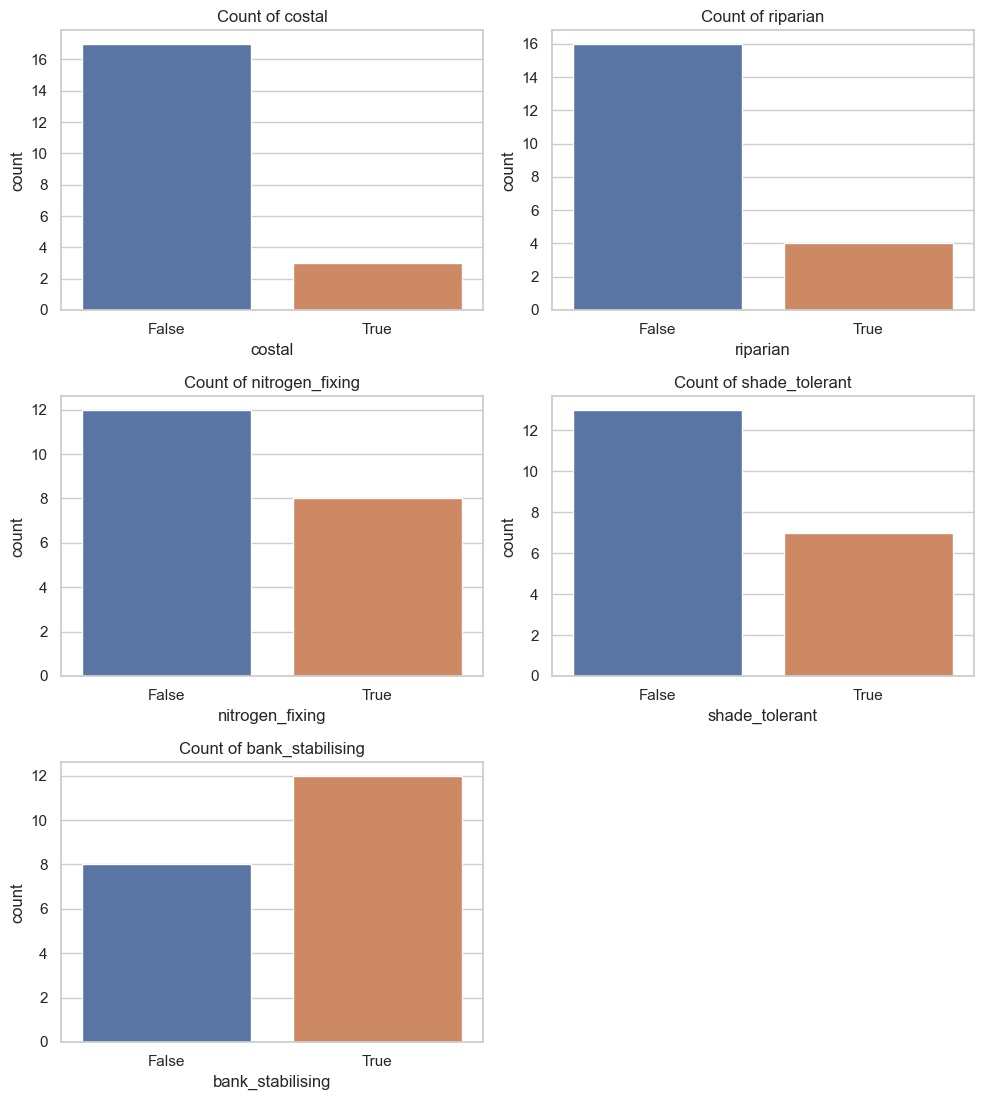

In [11]:
# Create bar charts for boolean columns
plt.figure(figsize=(10, 18))
for i, col in enumerate(tree_boolean_cols, 1):
    plt.subplot(5, 2, i)
    sns.countplot(x=tree_df[col], palette="deep", hue=tree_df[col], legend=False)
    plt.title(f"Count of {col}")
    plt.tight_layout()

In [12]:
def process_and_plot_list_column(df, column_name, title, colour_palette):
    """
    Function to process list-like columns and plot a horizontal bar plot.

    :param df: Dataframe containing the data
    :param column_name: Name of the column to plot
    :param title: String for plot title
    :param colour_palette: Seaborn colour palette
    :returns: None
    """
    # For the specified column, split the string by a comma to get a list
    # Explode the list, so each item gets its own row
    # Strip whitespace from the strings
    series = df[column_name].str.split(",").explode().str.strip()

    # Count the occurrences
    counts = series.value_counts()

    # Create DataFrame for plotting
    plot_df = counts.reset_index()
    plot_df.columns = ["Category", "Count"]

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=plot_df,
        x="Count",
        y="Category",
        palette=colour_palette,
        hue="Category",
        legend=False,
    )
    plt.title(title)
    plt.xlabel("Number of Species")
    plt.ylabel(column_name.replace("_", " ").title())
    plt.tight_layout()

    return None

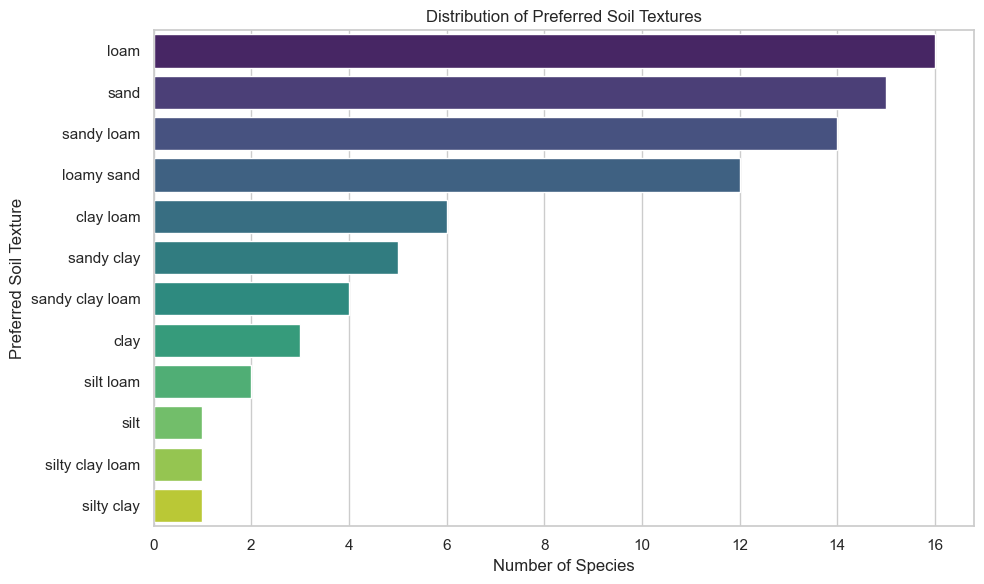

In [13]:
# Process 'preferred_soil_texture'
process_and_plot_list_column(
    tree_df,
    "preferred_soil_texture",
    "Distribution of Preferred Soil Textures",
    "viridis",
)

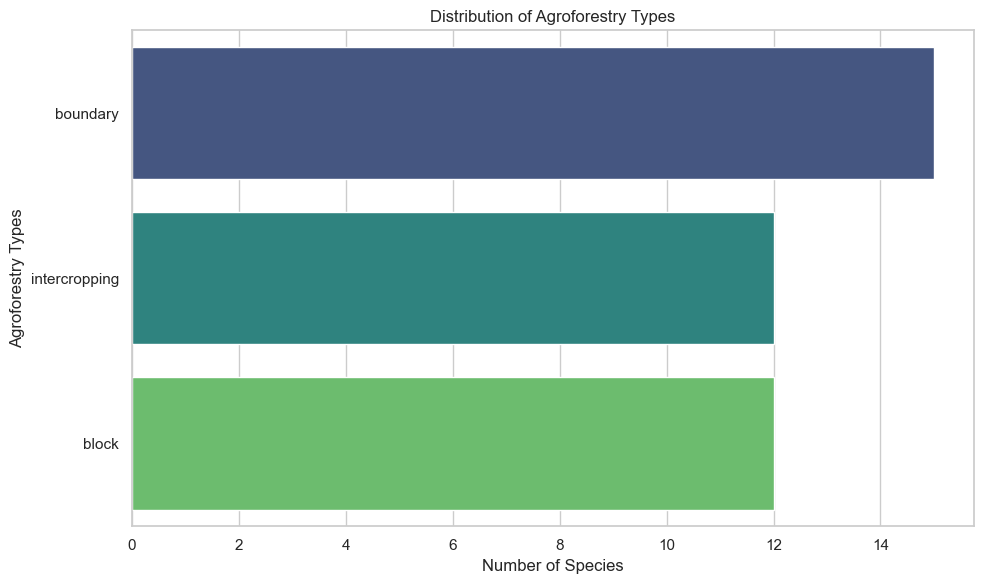

In [14]:
# Process 'agroforestry_types'
process_and_plot_list_column(
    tree_df, "agroforestry_types", "Distribution of Agroforestry Types", "viridis"
)

### Summary
**Data Structure:**
  * The dataset contains 20 entries and 18 columns.
  * Columns:
      * Identifiers: `species_id`, `species_name`, `species_common_name`
      * Environmental Factors (Numerical): `rainfall_mm_min/max`, `temperature_celsius_min/max`, `elevation_m_min/max`, `ph_min/max`
      * Characteristics (Categorical/Boolean): `preferred_soil_texture`, `costal`, `riparian`, `nitrogen_fixing`, `shade_tolerant`, `bank_stabilising`, `agroforestry_types`

**Data Quality:**
  * There are no missing values in any of the columns.
  * Data types appear appropriate (integers/floats for ranges, booleans for flags).

**Distributions & Statistics:**
  * Rainfall: Minimum rainfall requirements range from 200 mm to 2500 mm, while maximums go up to 5000 mm.
  * Temperature: Minimum temperatures range from 10 °C to 28 °C, and maximums from 28 °C to 40 °C.
  * Elevation: Most species start at 0 m elevation, with some tolerating up to 3000 m. There are a few species that require at least 400 m.
  * pH: Soil pH preferences generally span from acidic (min 4.0) to slightly alkaline (max 8.5).

**Visualisations:**
  * Numerical Distributions: The histograms show the spread of environmental tolerances. For example, `elevation_m_min` is heavily skewed towards 0, indicating many species can grow at sea level. There are only two species that can grow at high elevation.
  * Boolean Counts: The bar charts show the prevalence of traits like nitrogen fixing, shade tolerance and bank stabilising. They also highlight that there are not many species suitable for coastal or riparian environments.
  * Categorical Counts: The horizontal bar charts for the preferred soil texture and agroforestry types show:

    * Preferred Soil Textures:

      * Loam, Sand, and Sandy Loam are the most common preferred soil types, suitable for the majority of species in this dataset.
      * Finer textures like Silt and Silty Clay are less commonly supported.

    * Agroforestry Types:

      * Boundary planting is the most versatile use, applicable to 15 species.
      * Intercropping and Block planting are also widely supported, each suitable for 12 species.


## Clustering

### Encoding

In [15]:
# Encode the boolean feature as 0 and 1
for col in tree_boolean_cols:
    tree_df[col] = (
        tree_df[col]
        .astype(str)
        .str.strip()
        .map({"True": 1, "False": 0, "true": 1, "false": 0})
        .fillna(0)
        .astype(int)
    )

In [16]:
# List-like columns (One-hot encoding)
def get_dummies_from_list_col(df, col):
    normalised = df[col].str.replace(", ", ",")
    dummies = normalised.str.get_dummies(sep=",")
    dummies = dummies.add_prefix(f"{col}_")
    return dummies


tree_soil_dummies = get_dummies_from_list_col(tree_df, "preferred_soil_texture")
tree_agro_dummies = get_dummies_from_list_col(tree_df, "agroforestry_types")

In [17]:
# Combine all features
tree_features_df = pd.concat(
    [
        tree_df[tree_numerical_cols],
        tree_df[tree_boolean_cols],
        tree_soil_dummies,
        tree_agro_dummies,
    ],
    axis=1,
)

### Scaling

In [18]:
scaler = StandardScaler()
tree_scaled_features = scaler.fit_transform(tree_features_df)

### k-means clustering

In [19]:
# Determine optimal k (Silhouette Score)
tree_best_k = 2
tree_best_score = -1

for k in range(2, 6):
    tree_kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = tree_kmeans.fit_predict(tree_scaled_features)
    score = silhouette_score(tree_scaled_features, labels)
    if score > tree_best_score:
        tree_best_score = score
        tree_best_k = k

print(
    f"Optimal number of clusters (k) found: {tree_best_k} (Silhouette Score: {tree_best_score:.3f})"
)

Optimal number of clusters (k) found: 2 (Silhouette Score: 0.187)


In [20]:
# Apply K-Means using best k
tree_kmeans = KMeans(n_clusters=tree_best_k, random_state=42, n_init=10)
tree_df["Cluster"] = tree_kmeans.fit_predict(tree_scaled_features)

In [21]:
# Get the centroids of each cluster
tree_centroids = pd.DataFrame(
    tree_kmeans.cluster_centers_, columns=tree_features_df.columns
)

# Calculate the difference between Clusters
# Get the absolute value difference
tree_diff = tree_centroids.diff().iloc[1].abs()

# Sort to find the most important features
tree_sorted_diff = tree_diff.sort_values(ascending=False)

# Display the results
print("Top features driving the species cluster separation:")
print(tree_sorted_diff.head(14))

Top features driving the species cluster separation:
preferred_soil_texture_clay loam          1.909407
preferred_soil_texture_sandy clay loam    1.718750
preferred_soil_texture_silt loam          1.666667
rainfall_mm_min                           1.478876
agroforestry_types_boundary               1.443376
preferred_soil_texture_sand               1.443376
preferred_soil_texture_silty clay         1.147079
preferred_soil_texture_silt               1.147079
preferred_soil_texture_silty clay loam    1.147079
shade_tolerant                            1.048285
rainfall_mm_max                           0.990309
riparian                                  0.937500
bank_stabilising                          0.893043
preferred_soil_texture_loamy sand         0.893043
Name: 1, dtype: float64


Soil texture dominates the list of features driving the separation between the clusters. However, because the soil texture often correlates to how the trees are used and the environment they are planted in, I will focus on the environmental and usage features from the importance lists to describe the clustering.

In [22]:
# Feature for investigation
tree_features_of_interest = [
    "rainfall_mm_min",
    "bank_stabilising",
    "riparian",
    "shade_tolerant",
]

# Add 'boundary' for analysis
tree_df["agroforestry_boundary"] = tree_agro_dummies["agroforestry_types_boundary"]
tree_features_of_interest.append("agroforestry_boundary")

# Calculate averages per cluster
tree_summary = tree_df.groupby("Cluster")[tree_features_of_interest].mean().T
tree_summary.columns = ["Cluster 0", "Cluster 1"]

print("Key Statistics for Species Classification:")
print(tree_summary)

Key Statistics for Species Classification:
                       Cluster 0  Cluster 1
rainfall_mm_min         913.4375    1725.00
bank_stabilising          0.6875       0.25
riparian                  0.1250       0.50
shade_tolerant            0.2500       0.75
agroforestry_boundary     0.8750       0.25


| **Feature** | **Cluster 0** | **Cluster 1** | **Interpretation** |
| :--- | :--- | :--- | :--- |
| Min Rainfall | 913 mm | 1725 mm | Cluster 0 species can survive with much less water, so are hardy. Cluster 1 requires high rainfall. |
| Bank Stabilising | 69% | 25% | The majority of Cluster 0 species can be used for stabilising banks. |
| Riparian | 12% | 50% | Cluster 1 has a much higher concentration of river-dwelling (Riparian) species. |
| Shade Tolerant | 25% | 75% | Most Cluster 1 species can grow in the shade (Shade Tolerant), unlike Cluster 0. |
| Boundary Planting | 88% | 25% | Almost all Cluster 0 species are suitable for boundary planting. |

#### Description of clusters

*  Cluster 0 - Hardy, Boundary and Stabilising
*  Cluster 1 - High Rainfall, Riparian & Shade Tolerant


In [23]:
# PCA for Visualisation
tree_pca = PCA(n_components=2)
tree_principal_components = tree_pca.fit_transform(tree_scaled_features)
tree_pca_df = pd.DataFrame(data=tree_principal_components, columns=["PC1", "PC2"])
tree_pca_df["Cluster"] = tree_df["Cluster"]
tree_pca_df["Species"] = tree_df["species_name"]

In [24]:
# Get the correlation between original features and the PCs
tree_loadings = pd.DataFrame(
    tree_pca.components_.T, columns=["PC1", "PC2"], index=tree_features_df.columns
)

# Sort to find the top drivers for each component
tree_top_pc1 = tree_loadings.reindex(
    tree_loadings["PC1"].abs().sort_values(ascending=False).index
).head(10)
tree_top_pc2 = tree_loadings.reindex(
    tree_loadings["PC2"].abs().sort_values(ascending=False).index
).head(10)

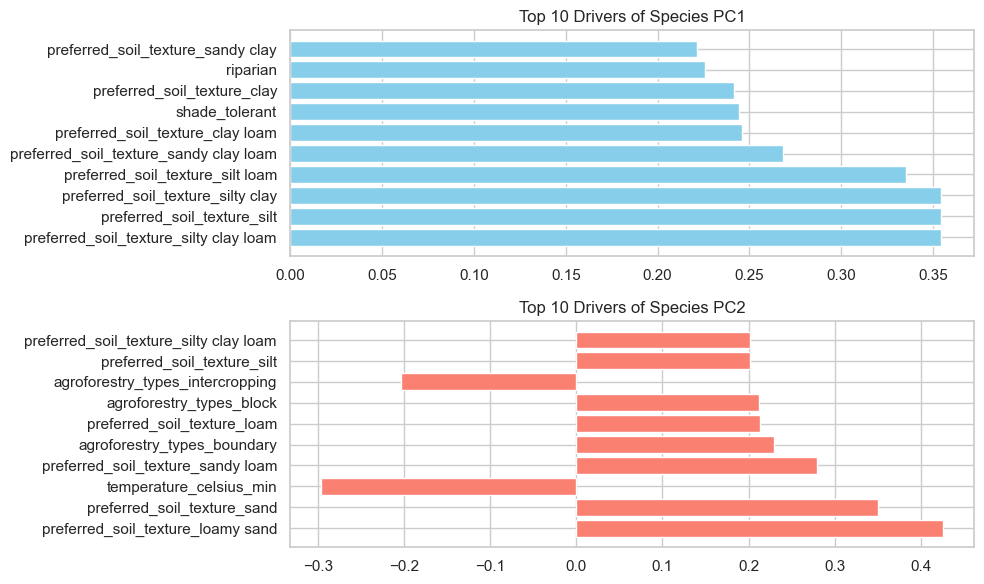

In [25]:
# Plot
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.barh(tree_top_pc1.index, tree_top_pc1["PC1"], color="skyblue")
plt.title("Top 10 Drivers of Species PC1")

plt.subplot(2, 1, 2)
plt.barh(tree_top_pc2.index, tree_top_pc2["PC2"], color="salmon")
plt.title("Top 10 Drivers of Species PC2")

plt.tight_layout()

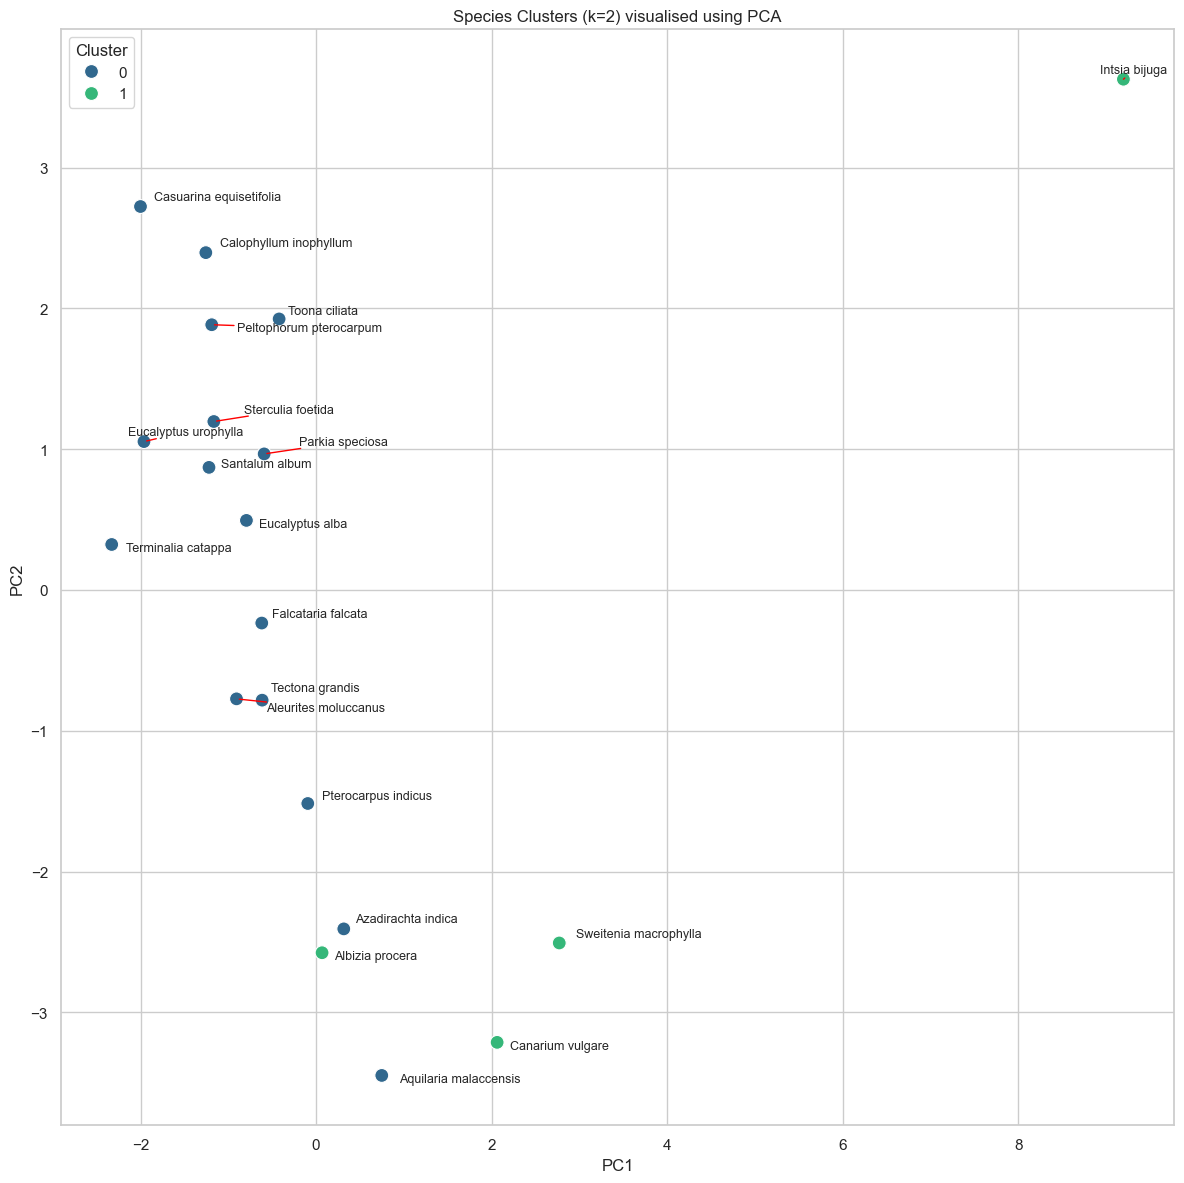

In [26]:
# Scatter plot of trees using PC1 and PC2 as axes
plt.figure(figsize=(12, 12))
sns.scatterplot(
    x="PC1", y="PC2", hue="Cluster", data=tree_pca_df, palette="viridis", s=100
)
plt.title(f"Species Clusters (k={tree_best_k}) visualised using PCA")

texts = []
# Annotate points
for i in range(tree_pca_df.shape[0]):
    texts.append(
        plt.text(
            tree_pca_df.PC1[i], tree_pca_df.PC2[i], tree_pca_df.Species[i], fontsize=9
        )
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", color="red"))
plt.tight_layout()
plt.show()

#### Principal components

PC1 seems to capture the difference between species that need fine, silty soils vs those that are hardy stabilisers.

  * Positive Side (+): Strongly driven by Silt and Clay textures (`silty clay loam`, `silt`, `silt loam`). If a species is far to the right, it likely needs these specific, finer soils.
  * Negative Side (-): Driven by Bank Stabilising and Coastal traits. If a species is far to the left, it is likely a hardy coastal or riverbank stabiliser.

PC2 separates species based on their preference for sandy soils vs those that need high temperatures/rainfall.

  * Positive Side (+): Dominated by Sand and Loamy Sand. Species high up on the chart are sand-lovers.
  * Negative Side (-): Driven by Temperature (Min), Rainfall, and Shade Tolerance. Species low down on the chart tend to be heat-loving, shade-tolerant, or high-rainfall species.

#### Scatter plot summary

  * Moving Right (PC1 \> 0): Species that prefer complex, silty/clay soils.
  * Moving Left (PC1 \< 0): Tough, bank-stabilising species.
  * Moving Up (PC2 \> 0): Find the sand-loving species.
  * Moving Down (PC2 \< 0): Find the heat/rain-loving, shade-tolerant species.

### Visualistion of cluster allocation using a Decsion Tree

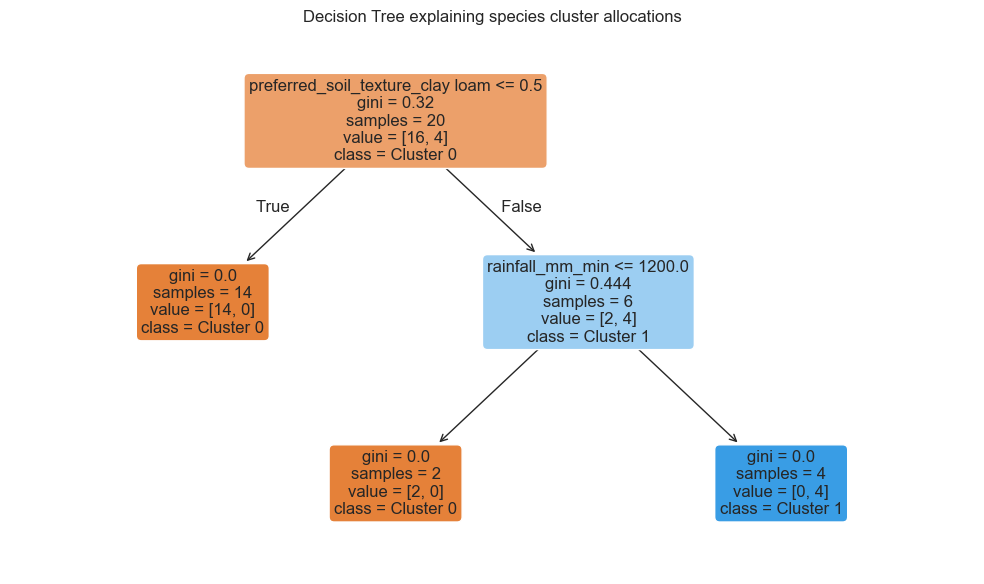

In [27]:
# Train Decision Tree
# X = Original Features (for readable rules), y = Cluster Labels
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=1)
tree_clf.fit(tree_features_df, tree_df["Cluster"])

# Plot the Tree
plt.figure(figsize=(10, 6))
plot_tree(
    tree_clf,
    feature_names=tree_features_df.columns,
    class_names=["Cluster 0", "Cluster 1"],
    filled=True,
    rounded=True,
    fontsize=12,
)
plt.title("Decision Tree explaining species cluster allocations")
plt.tight_layout()
plt.show()


### Decision Tree analysis
The decision tree confirms that the separation between the two species groups is driven by just two key variables: Soil Texture and Rainfall.

* Does the species tolerate Clay Loam?
  * No: The species is immediately assigned to Cluster 0 (Hardy/Boundary). This suggests that Cluster 0 species are generally defined by not requiring this specific heavy soil type (they tend to prefer sand/loam).
  * Yes: If the species does like Clay Loam, move to the next check.

* Is the Minimum Rainfall \> 1200 mm?
  * No: Even if it likes Clay Loam, if it can survive on less than 1200 mm of rain, it is assigned to Cluster 0. This reinforces Cluster 0 as the "Hardy" group.
  * Yes: If it likes Clay Loam and requires high rainfall (\>1200 mm), it is assigned to Cluster 1 (High Rainfall/Riparian).
